***IMPORTING DATASET***

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras import models
from keras.models import Sequential 
from keras.layers import *
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/olivetti_faces.npy',)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***SHUFFLING AND SPLITTING DATASET ***

In [2]:
from numpy import random
arr=[]
for i in range(40):
  narr=np.random.choice(10, 5, replace=False)
  for k in range(5):
    arr.append(data[10*i+narr[k]]);   

positive = []
anchor = []
negative =[]
for i in range(40):
  for j in range(5):
    for k in range(5):
      if (k!=j):
        for l in range(200):
          if (not((5*i<=l) and ((5*i+4)>=l))):
            positive.append(arr[5*i + j])
            anchor.append(arr[5*i + k])
            negative.append(arr[l])

shuffle=np.random.choice(156000, 156000, replace=False)
positive_final=[]
anchor_final=[]
negative_final=[]
for i in range(156000):
  positive_final.append(positive[shuffle[i]])
  anchor_final.append(anchor[shuffle[i]])
  negative_final.append(negative[shuffle[i]])

***Empty arrays***

In [3]:
anchor_train=[]
anchor_validation=[]
anchor_test=[]
positive_train=[]
positive_validation=[]
positive_test=[]
negative_train=[]
negative_validation=[]
negative_test=[]


***Dividing the data into train,test,validation***

In [4]:
for i in range(117000):
  anchor_train.append(anchor_final[i])
  positive_train.append(positive_final[i])
  negative_train.append(negative_final[i])
for i in range(117000,136500):
  anchor_validation.append(anchor_final[i])
  positive_validation.append(positive_final[i])
  negative_validation.append(negative_final[i])
for i in range(136500,156000):
  anchor_test.append(anchor_final[i])
  positive_test.append(positive_final[i])
  negative_test.append(negative_final[i])

#Converting into numpy array
anchor_train=np.array(anchor_train)
anchor_validation=np.array(anchor_validation)
anchor_test=np.array(anchor_test)
positive_train=np.array(positive_train)
positive_validation=np.array(positive_validation)
positive_test=np.array(positive_test)
negative_train=np.array(negative_train)
negative_validation=np.array(negative_validation)
negative_test=np.array(negative_test)
#reshaping
anchor_t=anchor_train.reshape((117000,64,64,1))
positive_t=positive_train.reshape((117000,64,64,1))
negative_t=negative_train.reshape((117000,64,64,1))
anchor_v=anchor_validation.reshape((19500,64,64,1))
anchor_tt=anchor_test.reshape((19500,64,64,1))
positive_tt=positive_test.reshape((19500,64,64,1))
positive_v=positive_validation.reshape((19500,64,64,1))
negative_tt=negative_test.reshape((19500,64,64,1))
negative_v=negative_validation.reshape((19500,64,64,1))

***Making CNN***

In [5]:
from keras.layers import Input
def cnn():
  model=Sequential()
  model.add(Conv2D(32,5,input_shape=(64,64,1), activation="relu"))
  model.add(MaxPooling2D(2))
  model.add(Conv2D(64,3, activation="relu"))
  model.add(MaxPooling2D(2))
  model.add(Conv2D(128,3, activation="relu"))    
  model.add(MaxPooling2D(2))         
  model.add(Flatten())
  model.add(Dense(128,activation="sigmoid"))
  return model

***Feature detection***

In [6]:
fd=cnn()
anchor_train=Input(shape=(64,64,1))
positive_train=Input(shape=(64,64,1))
negative_train=Input(shape=(64,64,1))
anchor_feature= fd(anchor_train)
positive_feature=fd(positive_train)
negative_feature=fd(negative_train)
final_features=[anchor_feature,positive_feature,negative_feature]


***TRAINING SIAMESE MODEL***

In [7]:
siamese_network=models.Model(inputs=[anchor_train,positive_train,negative_train], outputs=final_features)
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          683136      input_1[0][0]                    
                                                                 input_2[0][0]                

***TRIPLET LOSS***

In [8]:
ap=tf.math.square(anchor_feature-positive_feature)
an=tf.math.square(anchor_feature-negative_feature)
loss= tf.keras.backend.sum(ap-an+0.4,axis=1)
loss=tf.maximum(loss,0)
loss=tf.keras.backend.mean(loss)
siamese_network.add_loss(loss)

***COMPILING AND TRAINING***



In [9]:
siamese_network.compile(optimizer='adam',metrics='accuracy')
x1=[anchor_tt,positive_tt,negative_tt]
X=[anchor_t,positive_t,negative_t]
v=[anchor_v,positive_v,negative_v]
y1=np.zeros((117000,128))
y2=np.zeros((19500,128))
y3=np.zeros((19500,128))
y=np.concatenate((y1,y2,y3))
history=siamese_network.fit(X,y1,batch_size=32,validation_data=(v,y2), epochs=30)
#keras.models.save_model('/content/drive/MyDrive/ML PROJECT COPY')

Epoch 1/30
3657/3657 [==============================] - 73s 15ms/step - loss: 25.2539 - sequential_accuracy: 0.1339 - sequential_1_accuracy: 0.1329 - sequential_2_accuracy: 0.1339 - val_loss: 6.2258 - val_sequential_accuracy: 0.3349 - val_sequential_1_accuracy: 0.3357 - val_sequential_2_accuracy: 0.3281
Epoch 2/30
3657/3657 [==============================] - 52s 14ms/step - loss: 5.8545 - sequential_accuracy: 0.3436 - sequential_1_accuracy: 0.3432 - sequential_2_accuracy: 0.3415 - val_loss: 5.7554 - val_sequential_accuracy: 0.4487 - val_sequential_1_accuracy: 0.4487 - val_sequential_2_accuracy: 0.4458
Epoch 3/30
3657/3657 [==============================] - 52s 14ms/step - loss: 4.6922 - sequential_accuracy: 0.4213 - sequential_1_accuracy: 0.4219 - sequential_2_accuracy: 0.4190 - val_loss: 3.8139 - val_sequential_accuracy: 0.3822 - val_sequential_1_accuracy: 0.3829 - val_sequential_2_accuracy: 0.3802
Epoch 4/30
3657/3657 [==============================] - 52s 14ms/step - loss: 3.7279 - 

***LOSS , VAL_lOSS Graph***

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML PROJECT COPY/assets


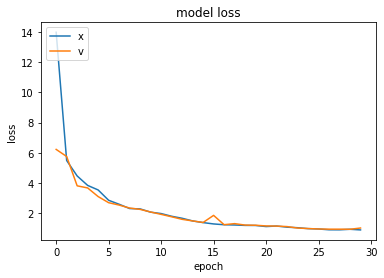

In [10]:
siamese_network.save('/content/drive/MyDrive/ML PROJECT COPY')

# v---->validation loss and x---->loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['x','v'],loc='upper left')
plt.show()

***TESTING***

In [45]:
accurate=0
inaccurate=0
threshold=104
for p in range(19500):
  anchor_t_extraction=fd(anchor_tt[p].reshape(1,64,64,1))
  positive_t_extraction=fd(positive_tt[p].reshape(1,64,64,1))
  negative_t_extraction=fd(negative_tt[p].reshape(1,64,64,1))
  APF_extraction=(anchor_t_extraction-positive_t_extraction)**2
  ANF_extraction=(anchor_t_extraction-negative_t_extraction)**2

  APF_extraction=tf.keras.backend.sum(APF_extraction)
  ANF_extraction=tf.keras.backend.sum(ANF_extraction)

  if APF_extraction < threshold:
    accurate+=1
  if APF_extraction > threshold:
    inaccurate+=1
  if ANF_extraction > threshold:
    accurate+=1
  if ANF_extraction > threshold:
    inaccurate+=1

***Finding Accuracy***

In [46]:
accuracy=(accurate/(accurate+inaccurate))
print(accuracy*100)

99.86702127659575


***Using Haarcascade Classifier***

Total number of faces detected=17


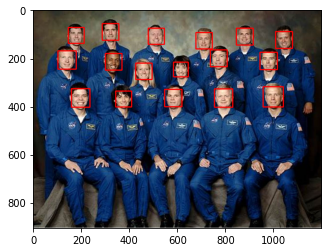

In [34]:
import cv2
face_casscade= cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")
img= cv2.imread(r"/content/NASA.jpg")
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
faces= face_casscade.detectMultiScale(gray,1.367,5)
for (x,y,w,h) in faces:
  cv2.rectangle(img,(x,y),(x+w, y+h),(255,0,0),3)
print("Total number of faces detected="+str(len(faces)))
plt.imshow(img)


***THANK YOU***